In [1]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import pylab as pl

from sklearn.tree import export_graphviz
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics
from scipy.sparse import csr_matrix
from numpy import *
from matplotlib import cm
from math import sqrt
from Util import *
from IPython.display import display, HTML

##conda install tabulate
#pip install mlxtend  

Wall time: 1.42 s


In [2]:
user_rating_data = pd.read_table('data/u.data',na_values=['?'],delimiter="\t",header=None )
genre_data = pd.read_table('data/u.genre',na_values=['?'],delimiter="|",header=None)
info_data = pd.read_table('data/u.info',na_values=['?'],delimiter="|",header=None)
item_data = pd.read_table('data/u.item',na_values=['?'],delimiter="|",header=None,encoding='latin-1')
occupation_data = pd.read_table('data/u.occupation',na_values=['?'],delimiter="|",header=None)
user_data = pd.read_table('data/u.user',na_values=['?'],delimiter="|",header=None)

In [3]:
def print_df_info(df):
    print("Shape ",df.shape)
    print()
    display(df.head())

In [4]:
user_rating_data.columns = ['user_id','item_id','rating','timestamp']
print_df_info(user_rating_data)

Shape  (100000, 4)



,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
genre_data.columns=['Genre','Id']
print_df_info(genre_data)

Shape  (19, 2)



,Genre,Id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [6]:
item_data.columns = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
print_df_info(item_data)

Shape  (1682, 24)



,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
## strip off year from movie title
temp_arr = np.array(item_data['movie_title'])
title = []
for t in temp_arr:
    if( t.find('(') > -1):
        title.append(t[0:t.rindex('(')].strip())
    else:
        title.append(t)

print("title ",len(title))
item_data['movie_title']=title

print_df_info(item_data)

title  1682
Shape  (1682, 24)



,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
## keep movie id and movie title for future use
movie_data = item_data[['movie_id','movie_title']]
print_df_info(movie_data)

Shape  (1682, 2)



,movie_id,movie_title
0,1,Toy Story
1,2,GoldenEye
2,3,Four Rooms
3,4,Get Shorty
4,5,Copycat


In [9]:
info_data

,0
0,943 users
1,1682 items
2,100000 ratings


In [10]:
print_df_info(occupation_data)

Shape  (21, 1)



,0
0,administrator
1,artist
2,doctor
3,educator
4,engineer


In [11]:
user_data.columns= ['user_id','age','gender','occupation','zip code']
print_df_info(user_data)

Shape  (943, 5)



,user_id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [12]:
## check if any missing data in user data
print('Number of missing values across columns: \n',user_data.isnull().sum())

Number of missing values across columns: 
 user_id       0
age           0
gender        0
occupation    0
zip code      0
dtype: int64


In [13]:
## get the column with missing values
user_data.columns[user_data.isna().any()]

Index([], dtype='object')

In [14]:
user_data.columns


Index(['user_id', 'age', 'gender', 'occupation', 'zip code'], dtype='object')

In [15]:
## categorize age into 3 broad categories
age_discreet = pd.qcut(user_data.age,3, labels=['young', 'mid-age','old'])
print_df_info(age_discreet)


Shape  (943,)



0      young
1        old
2      young
3      young
4    mid-age
Name: age, dtype: category
Categories (3, object): [young < mid-age < old]

In [16]:
user_data['age_discreet'] = age_discreet
# user_data = user_data.groupby('age_discreet')
# user_data

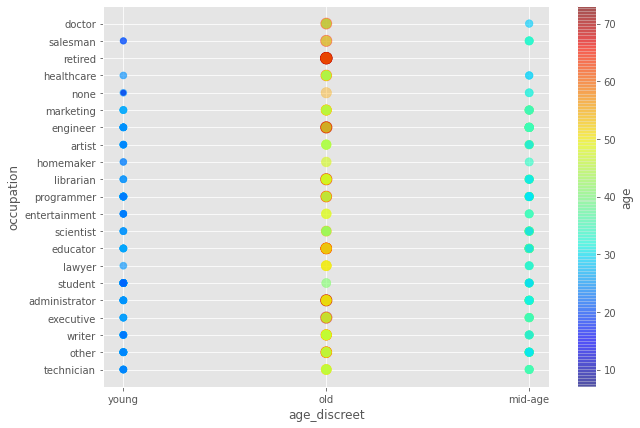

In [17]:
fig, ax = plt.subplots()
user_data.plot(y='occupation', x='age_discreet',kind='scatter',s=user_data.age*2, alpha=0.4,c="age", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(10,7),ax=ax)

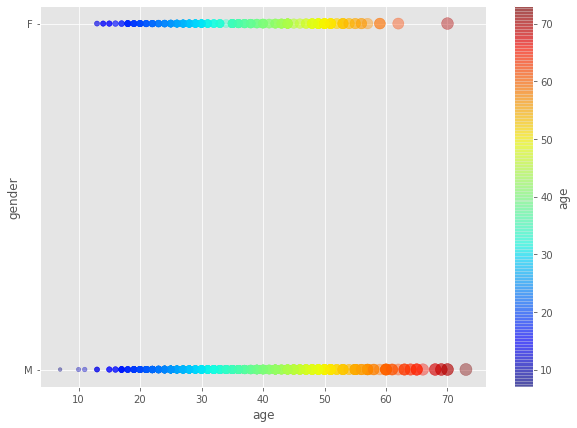

In [18]:
fig, ax = plt.subplots()
user_data.plot(y='gender', x='age',kind='scatter',s=user_data.age*2, alpha=0.4,c="age", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(10,7),ax=ax)

 ## Analyze User Rating Data

In [19]:
#Check for missing values
print('Number of missing values across columns: \n',user_rating_data.isnull().sum())

Number of missing values across columns: 
 user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64


In [20]:
#Five point summary 

user_rating_data.describe()['rating']

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [21]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(user_rating_data.rating.min()))
print('Maximum rating is: %d' %(user_rating_data.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


M:\apps\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


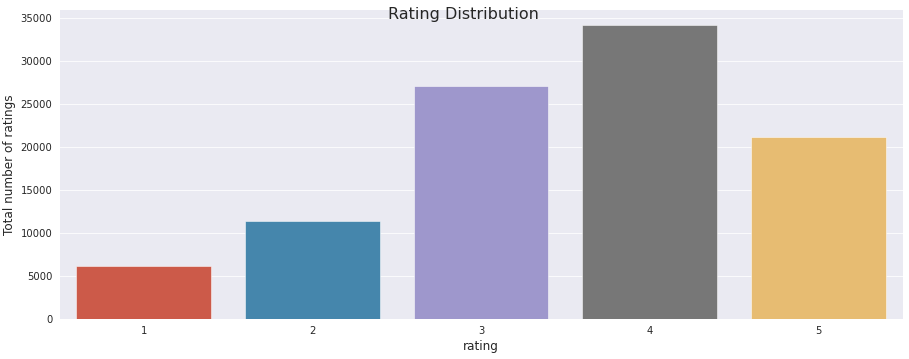

In [22]:
# Check the distribution of the rating
with sns.axes_style('darkgrid'):
    g = sns.factorplot("rating", data=user_rating_data, aspect=2.5,kind='count')
    g.set_ylabels("Total number of ratings")
    g.fig.suptitle('Rating Distribution', fontsize=16)

In [23]:
print("Total data ")
print("-"*40)
print("\nTotal no of ratings :",user_rating_data.shape[0])
print("Total No of Users   :", len(np.unique(user_rating_data.user_id)))
print("Total No of Movies  :", len(np.unique(user_rating_data.item_id)))

Total data 
----------------------------------------

Total no of ratings : 100000
Total No of Users   : 943
Total No of Movies  : 1682


In [24]:
#Dropping the Timestamp column
user_rating_data.drop(['timestamp'], axis=1,inplace=True)

In [25]:
#Analysis of rating given by the user 

no_of_rated_movies_per_user = user_rating_data.groupby(by='user_id')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user_id
405    737
655    685
13     636
450    540
276    518
Name: rating, dtype: int64

In [26]:
no_of_rated_movies_per_user.describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64

In [27]:
min_rating_count = no_of_rated_movies_per_user.min()
print(' min_rating_count ',min_rating_count)

 min_rating_count  20


In [28]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

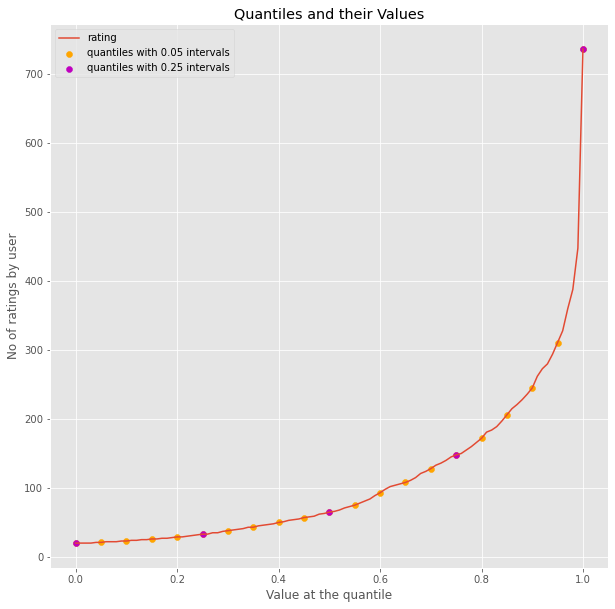

In [29]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [30]:
print('\n No of rated movies more than {} per user : {}\n'.format(min_rating_count, sum(no_of_rated_movies_per_user >= min_rating_count)) )


 No of rated movies more than 20 per user : 943



 ## Merge the user and user rating data to prepare the final data set

In [31]:

## merge movie and movie rating data
merged_df = item_data.merge(user_rating_data, how = 'inner', left_on=['movie_id'], right_on=['item_id'])
merged_df.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id,item_id,rating
0,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,308,1,4
1,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,287,1,5
2,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,148,1,4
3,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,280,1,4
4,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,66,1,3


In [32]:
user_data

,user_id,age,gender,occupation,zip code,age_discreet
0,1,24,M,technician,85711,young
1,2,53,F,other,94043,old
2,3,23,M,writer,32067,young
3,4,24,M,technician,43537,young
4,5,33,F,other,15213,mid-age
...,...,...,...,...,...,...
938,939,26,F,student,33319,young
939,940,32,M,administrator,02215,mid-age
940,941,20,M,student,97229,young
941,942,48,F,librarian,78209,old


In [33]:
## merge the user info
merged_df = merged_df.merge(user_data, how = 'inner', on=['user_id'])
merged_df.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,War,Western,user_id,item_id,rating,age,gender,occupation,zip code,age_discreet
0,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,308,1,4,60,M,retired,95076,old
1,4,Get Shorty,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,308,4,5,60,M,retired,95076,old
2,5,Copycat,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,308,5,4,60,M,retired,95076,old
3,7,Twelve Monkeys,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,308,7,4,60,M,retired,95076,old
4,8,Babe,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,308,8,5,60,M,retired,95076,old


In [34]:

print("Merged DaraFrame  - Shape ",merged_df.shape," \n\ncolumns ",merged_df.columns)

Merged DaraFrame  - Shape  (100000, 32)  

columns  Index(['movie_id', 'movie_title', 'release_date', 'video_release_date',
       'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children's',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'user_id', 'item_id', 'rating', 'age', 'gender',
       'occupation', 'zip code', 'age_discreet'],
      dtype='object')


In [35]:
## dropping uneccessary columns
final_dataset = merged_df.drop(columns=['release_date','video_release_date','IMDb_URL','item_id'])

In [36]:
## rename movie_id to item_id
updated_columnsNames = ['item_id', 'movie_title', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'user_id', 'rating', 'age',
       'gender', 'occupation', 'zip code', 'age_discreet']
final_dataset.columns = updated_columnsNames
print("\n final data set Shape ",final_dataset.shape," \n\ncolumns ",final_dataset.columns)


 final data set Shape  (100000, 28)  

columns  Index(['item_id', 'movie_title', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'user_id', 'rating', 'age', 'gender',
       'occupation', 'zip code', 'age_discreet'],
      dtype='object')


In [37]:
## make sure final data set does not have any missing values
final_dataset.isnull().sum()

item_id         0
movie_title     0
unknown         0
Action          0
Adventure       0
Animation       0
Children's      0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
user_id         0
rating          0
age             0
gender          0
occupation      0
zip code        0
age_discreet    0
dtype: int64

## 80-20 Split - Classifier and K-means Clustering

In [38]:
not_needed_columns = ['movie_title','age_discreet','zip code']

final_data = final_dataset.drop(columns=not_needed_columns,inplace=False)
## handle categorical data
final_data = pd.get_dummies(final_data)

rating_class = final_data['rating']

vs_matrix = final_data.drop(['rating'],axis=1)

#vs_matrix = final_data.copy()


vs_train, vs_test, vs_target_train, vs_target_test = train_test_split(vs_matrix,rating_class, test_size=0.2, random_state=33)


In [39]:
# Item ID to be removed for Classification
vs_train_rf = vs_train.drop(columns=['item_id'])
vs_test_rf = vs_test.drop(columns=['item_id'])

vs_target_train_rf = vs_target_train.copy()
vs_target_test_rf = vs_target_test.copy()

display(vs_test_rf.head())
display(vs_train_rf.head())

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
38901,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
98214,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
27146,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
73705,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
91474,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
4867,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
80281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20667,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30770,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
74987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
vs_train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
item_id,80000.0,426.010038,330.692439,1.0,175.0,322.0,632.0,1682.0
unknown,80000.0,0.000112,0.010606,0.0,0.0,0.0,0.0,1.0
Action,80000.0,0.256862,0.436906,0.0,0.0,0.0,1.0,1.0
Adventure,80000.0,0.136875,0.343717,0.0,0.0,0.0,0.0,1.0
Animation,80000.0,0.036038,0.186385,0.0,0.0,0.0,0.0,1.0
Children's,80000.0,0.071887,0.258303,0.0,0.0,0.0,0.0,1.0
Comedy,80000.0,0.297837,0.457311,0.0,0.0,0.0,1.0,1.0
Crime,80000.0,0.080463,0.272010,0.0,0.0,0.0,0.0,1.0
Documentary,80000.0,0.007625,0.086988,0.0,0.0,0.0,0.0,1.0
Drama,80000.0,0.398863,0.489667,0.0,0.0,0.0,1.0,1.0


In [41]:
data = vs_train
data.shape[1]

45

## Random Forest Classifier

In [42]:
# Item ID cannot be used for classification so use vs_train_rf, vs_test_rf

vs_matrix_rf = vs_matrix.drop(columns=['item_id'])
print(vs_train_rf.shape)
print(vs_test_rf.shape)

vs_train_rf.head()

(80000, 44)
(20000, 44)


,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
4867,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
80281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20667,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30770,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
74987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confussion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n")
    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred),"\n")
      
    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred),"\n")

In [44]:
%%time

dt = tree.DecisionTreeClassifier(criterion='gini')
dt = dt.fit(vs_train_rf, vs_target_train_rf)

Wall time: 832 ms


In [45]:
%%time

measure_performance(vs_test_rf, vs_target_test_rf, dt, show_confussion_matrix=False, show_classification_report=False)

Accuracy:0.343 

Wall time: 20 ms


In [46]:
%%time

rf = RandomForestClassifier(n_estimators=10, random_state=33)
rf = rf.fit(vs_train_rf, vs_target_train_rf)

Wall time: 1.46 s


In [47]:
%%time

measure_performance(vs_test_rf, vs_target_test_rf, rf, show_confussion_matrix=False, show_classification_report=False)

Accuracy:0.358 

Wall time: 90 ms


In [48]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 33, 'verbose': 0, 'warm_start': False}


In [49]:

def calc_params(X, y, clf, param_values, param_name, K):
    
    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing score arrays with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):

        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation
        cv = KFold(n_splits=K, shuffle=True, random_state=0)
        
        # iterate over the K folds
        j = 0
        for train, test in cv.split(X):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit(X[train], y[train])
            k_train_scores[j] = clf.score(X[train], y[train])
            k_test_scores[j] = clf.score(X[test], y[test])
            j += 1
            
        # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
        print(param_name, '=', param_value, "Train =", train_scores[i], "Test =", test_scores[i])
       
    # plot the training and testing scores in a log scale
    plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
    plt.plot(param_values, test_scores, label='X-Val', alpha=0.4, lw=2, c='g')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

In [50]:
msl = range(1,6)
print(msl)

range(1, 6)


min_samples_leaf = 1 Train = 0.7102281250000001 Test = 0.34776250000000003
min_samples_leaf = 2 Train = 0.5971875000000001 Test = 0.369525
min_samples_leaf = 3 Train = 0.5375812499999999 Test = 0.372525
min_samples_leaf = 4 Train = 0.5031937500000001 Test = 0.37535
min_samples_leaf = 5 Train = 0.48215 Test = 0.37435
Wall time: 30.8 s


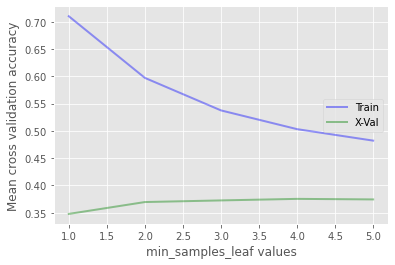

In [51]:
%%time

rf = RandomForestClassifier(n_estimators=10, random_state=33)
train_scores, test_scores = calc_params(vs_train_rf, vs_target_train_rf, rf, msl, 'min_samples_leaf', 5)

max_depth = 1 Train = 0.34137500000000004 Test = 0.34137500000000004
max_depth = 2 Train = 0.34139375000000005 Test = 0.341375
max_depth = 3 Train = 0.34181249999999996 Test = 0.34168750000000003
max_depth = 4 Train = 0.34749375000000005 Test = 0.34685
max_depth = 5 Train = 0.3484375 Test = 0.34673750000000003
max_depth = 6 Train = 0.353796875 Test = 0.35026250000000003
max_depth = 7 Train = 0.35858750000000006 Test = 0.3521125
max_depth = 8 Train = 0.36525625 Test = 0.35413750000000005
max_depth = 9 Train = 0.37528125 Test = 0.355525
max_depth = 10 Train = 0.387225 Test = 0.3595
Wall time: 23.8 s


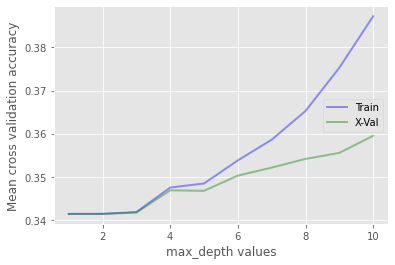

In [52]:
%%time

m_depth = [1,2,3,4,5,6,7,8,9,10]

rf = RandomForestClassifier(n_estimators=10, random_state=33)
train_scores, test_scores = calc_params(vs_train_rf, vs_target_train_rf, rf, m_depth, 'max_depth', 5)

In [53]:
nest = range(5, 101, 5)
print(nest)

range(5, 101, 5)


n_estimators = 5 Train = 0.6873875 Test = 0.3429125
n_estimators = 10 Train = 0.7102281250000001 Test = 0.34776250000000003
n_estimators = 15 Train = 0.716384375 Test = 0.35125
n_estimators = 20 Train = 0.718490625 Test = 0.35185
n_estimators = 25 Train = 0.719509375 Test = 0.3512375
n_estimators = 30 Train = 0.7199718749999999 Test = 0.35108750000000005
n_estimators = 35 Train = 0.7201531250000001 Test = 0.35196249999999996
n_estimators = 40 Train = 0.720303125 Test = 0.3533625
n_estimators = 45 Train = 0.7204062499999999 Test = 0.3524625
n_estimators = 50 Train = 0.720425 Test = 0.353425
n_estimators = 55 Train = 0.720434375 Test = 0.3536875
n_estimators = 60 Train = 0.720475 Test = 0.354
n_estimators = 65 Train = 0.7204843750000001 Test = 0.35356249999999995
n_estimators = 70 Train = 0.7204875000000001 Test = 0.354225
n_estimators = 75 Train = 0.720490625 Test = 0.35445000000000004
n_estimators = 80 Train = 0.7204937499999999 Test = 0.35400000000000004
n_estimators = 85 Train = 0.72

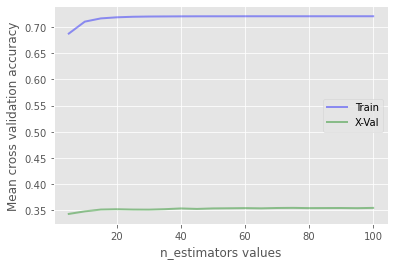

In [54]:
%%time

rf = RandomForestClassifier(n_estimators=10, random_state=33)
train_scores, test_scores = calc_params(vs_train_rf, vs_target_train_rf, rf, nest, 'n_estimators', 5)

In [55]:
%%time

rf = RandomForestClassifier(n_estimators=20, min_samples_leaf=4, max_depth=6)
rf = rf.fit(vs_train_rf, vs_target_train_rf)

measure_performance(vs_test_rf, vs_target_test_rf, rf, show_confussion_matrix=False, show_classification_report=False)

Accuracy:0.352 

Wall time: 831 ms


In [56]:
rf.feature_importances_

array([0.00000000e+00, 1.82459774e-02, 1.63120137e-02, 1.71685935e-02,
       6.75767846e-03, 5.77797389e-02, 7.22327740e-03, 2.86519880e-03,
       1.34251368e-01, 8.59265708e-03, 3.36205620e-02, 2.29708213e-02,
       5.28715777e-03, 8.49996564e-03, 1.68475360e-02, 1.01548351e-02,
       2.34319795e-02, 7.50787003e-02, 1.58415868e-03, 1.13384374e-01,
       1.28569655e-01, 2.39338112e-02, 3.23571291e-02, 5.96725605e-03,
       1.07937345e-02, 1.09742995e-04, 6.92623011e-03, 4.04600228e-03,
       3.67007096e-03, 2.59704071e-02, 1.17832846e-01, 6.69479831e-04,
       5.20189233e-03, 1.49579736e-03, 1.21423723e-03, 1.04724727e-03,
       2.52707690e-03, 3.58011760e-03, 1.23580660e-02, 1.47789640e-03,
       1.80560853e-03, 3.41511801e-03, 1.06389350e-03, 2.39100894e-02])

In [57]:
def plot_feature_importances(model, n_features, feature_names):
    plt.figure(figsize=(20,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


Wall time: 62 ms


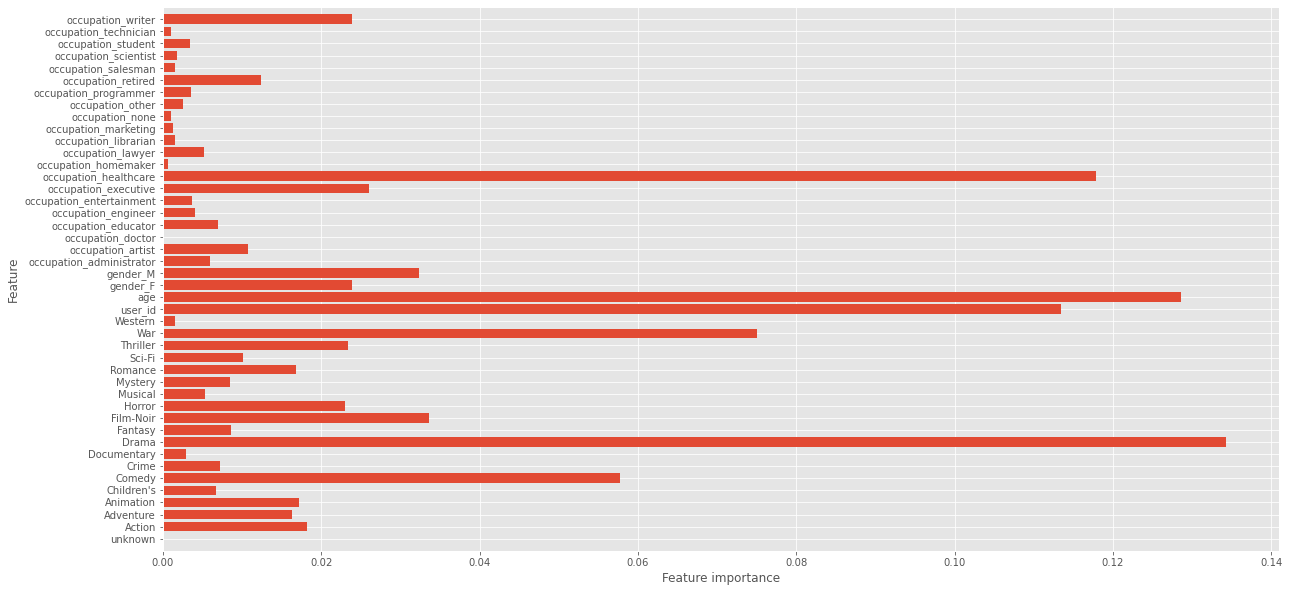

In [58]:
%%time
features = vs_matrix_rf.columns.values
plot_feature_importances(rf, len(features), features)

In [59]:
%%time
rf.estimators_[:3]

Wall time: 0 ns


[DecisionTreeClassifier(max_depth=6, max_features='auto', min_samples_leaf=4,
                        random_state=1174224390),
 DecisionTreeClassifier(max_depth=6, max_features='auto', min_samples_leaf=4,
                        random_state=1725992616),
 DecisionTreeClassifier(max_depth=6, max_features='auto', min_samples_leaf=4,
                        random_state=96150792)]

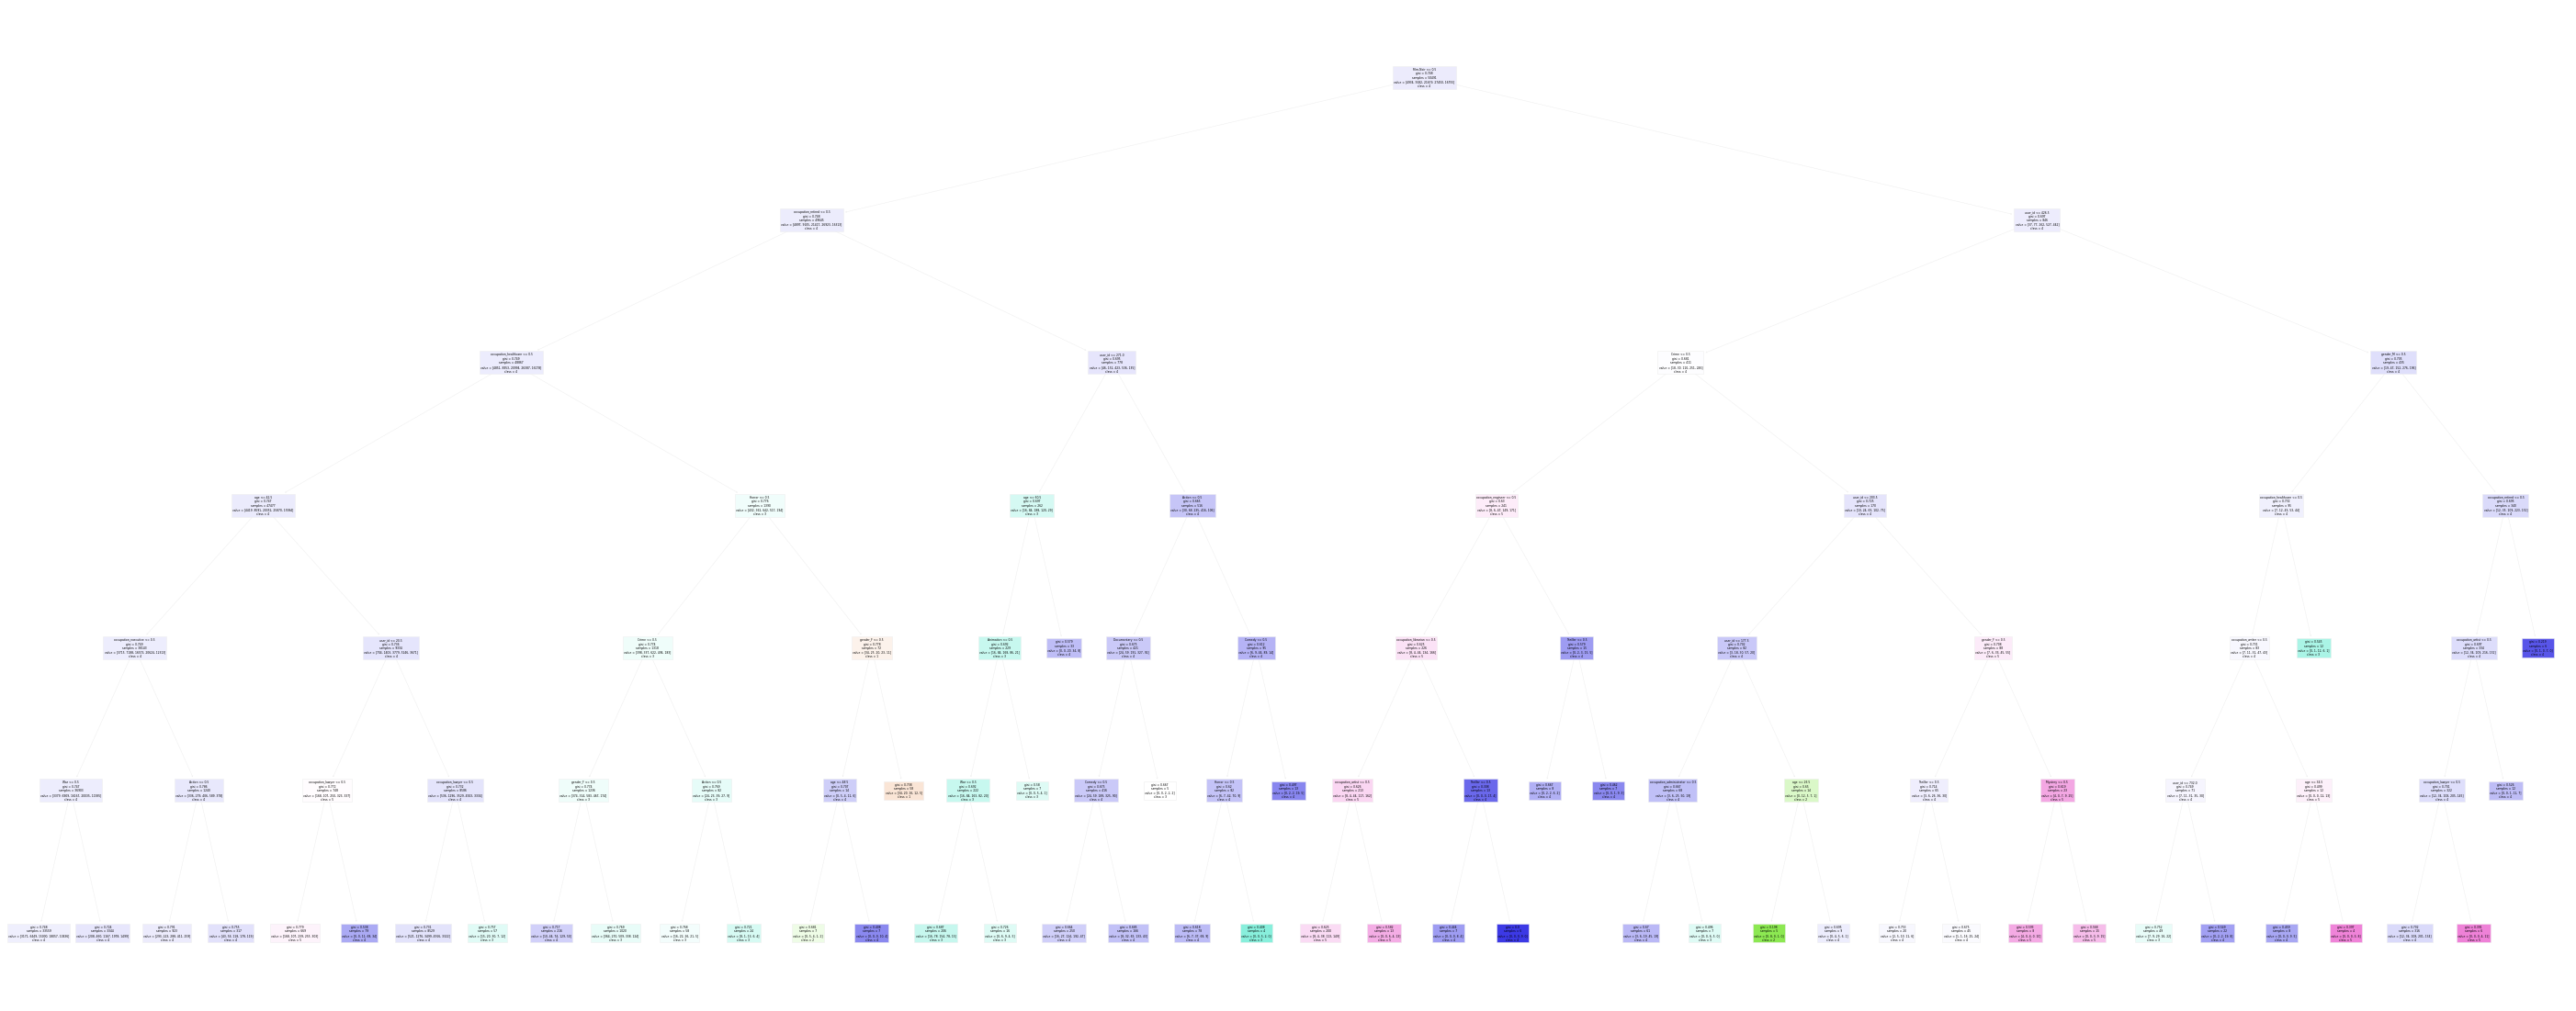

In [60]:
fig, ax = plt.subplots(figsize=(50,20))
tree.plot_tree(rf.estimators_[0], feature_names=features, class_names=["1","2","3","4","5"], filled=True, ax=ax);

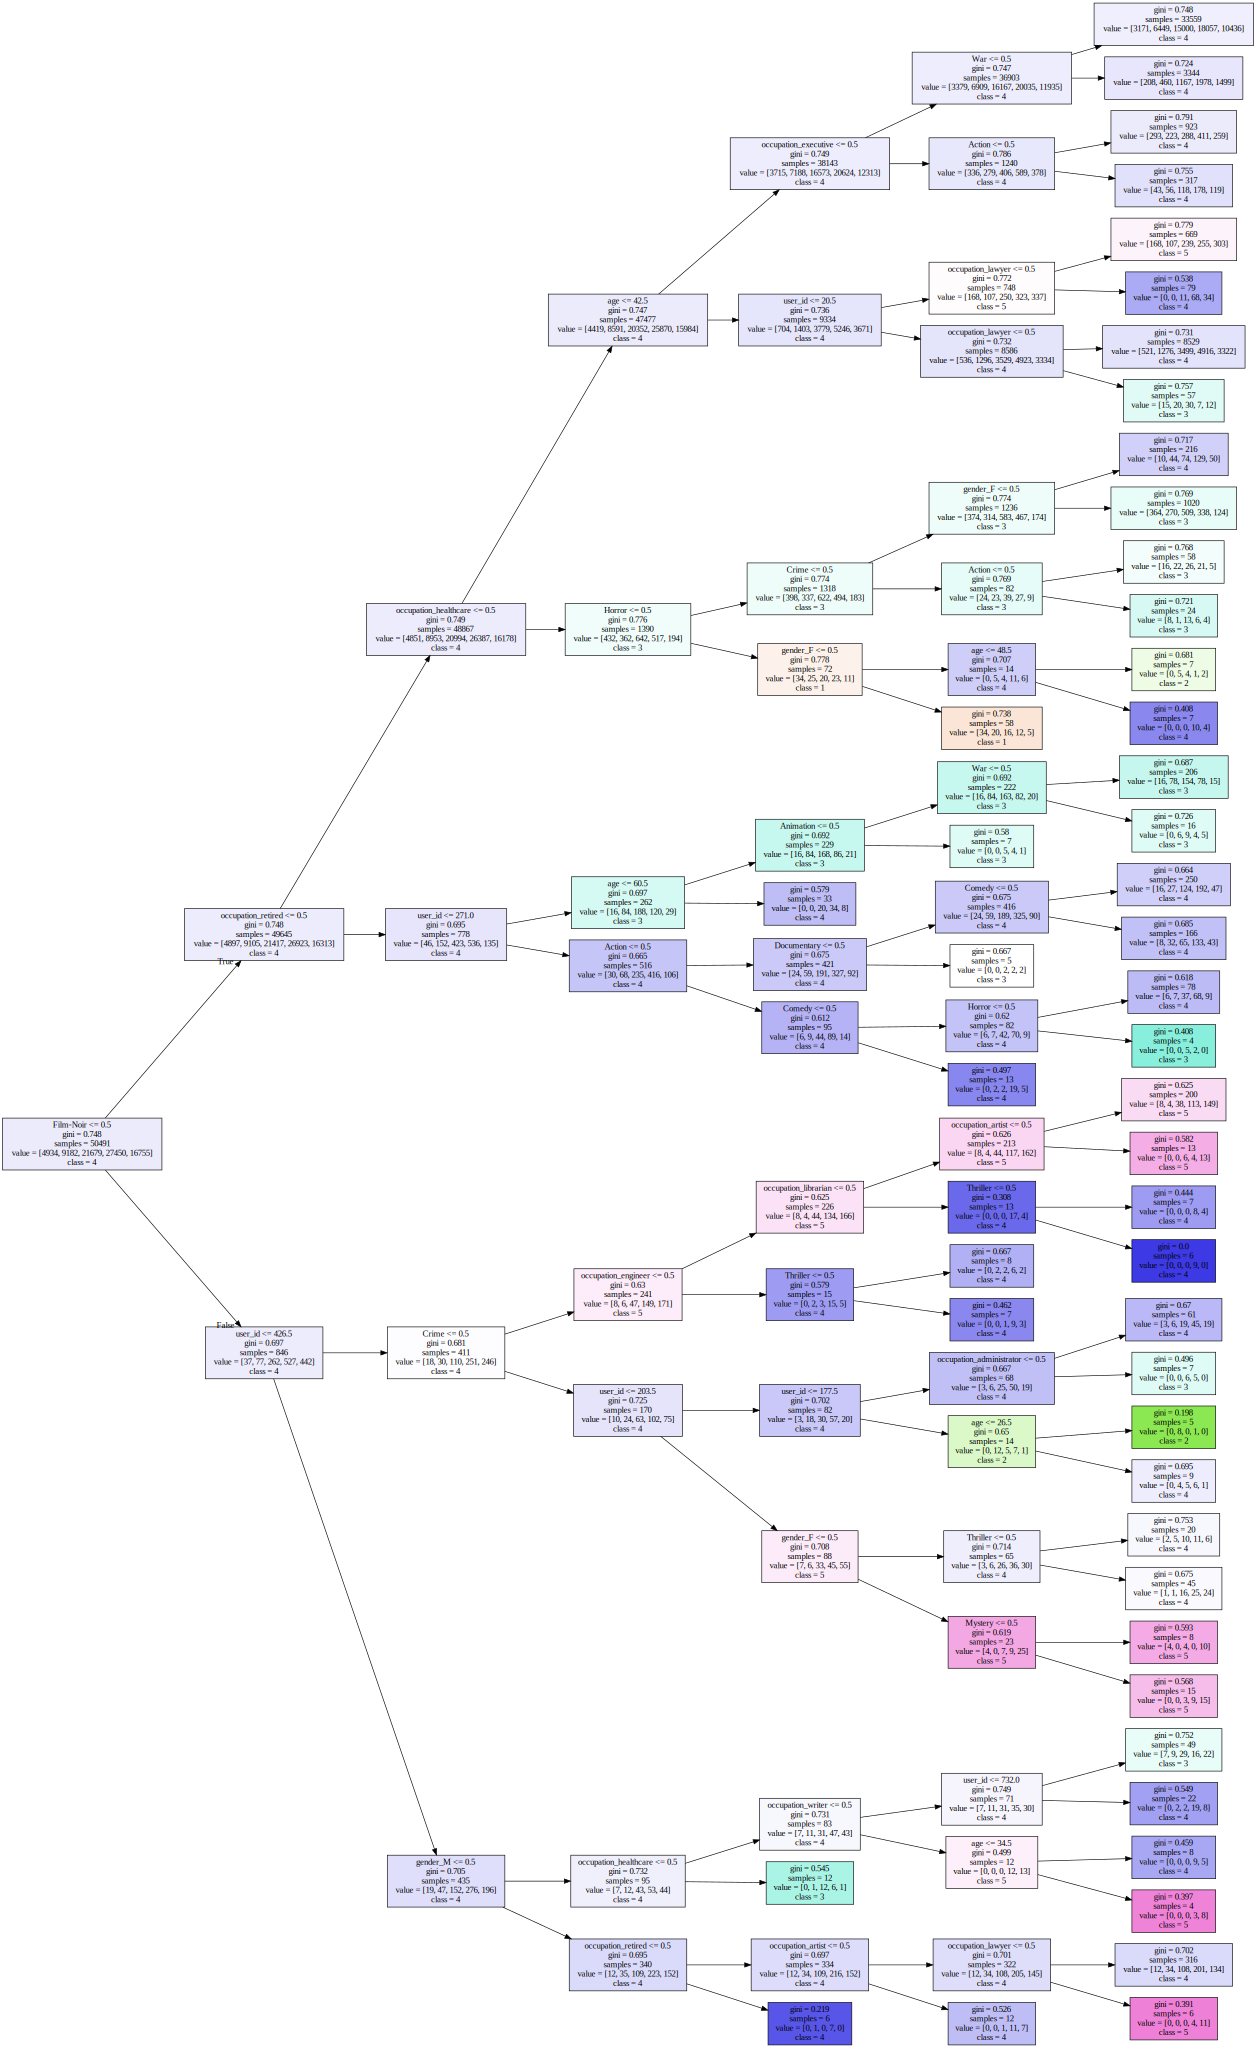

In [61]:
dot_data = export_graphviz(rf.estimators_[0],out_file=None, feature_names=features, 
                           class_names=["1","2","3","4","5"], filled=True, rotate=True)
graph = graphviz.Source(dot_data)
graph

### K Means Cluster and predict clusters for Test Set from 80-20 split

In [62]:
print('training Data')
print_df_info(data)

training Data
Shape  (80000, 45)



,item_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
4867,419,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
80281,479,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20667,354,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30770,202,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
74987,447,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
test_data = np.mat(vs_test)

print("Test Data Set")
print_df_info(vs_test)

Test Data Set
Shape  (20000, 45)



,item_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
38901,744,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
98214,315,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
27146,537,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
73705,191,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
91474,328,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [64]:
%%time

wcss = []

k_range=12

for i in range(1, k_range):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(final_data)
    wcss.append(kmeans.inertia_)

Wall time: 53 s


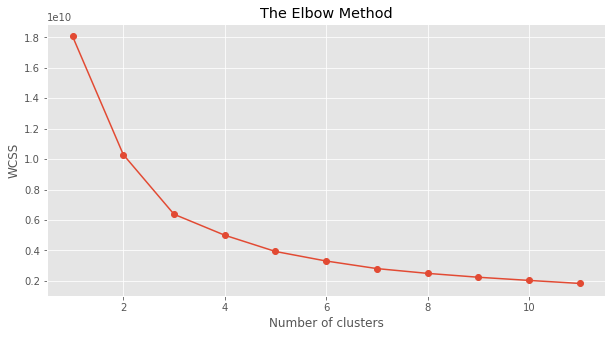

In [65]:
plt.figure(figsize=(10,5))
plt.plot(range(1, k_range,1), wcss,marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

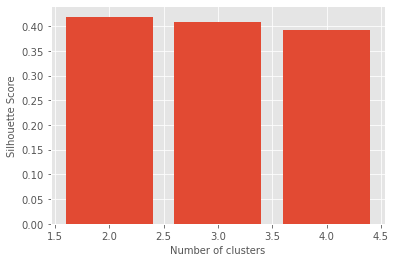

Wall time: 4min 27s


In [66]:
%%time

## get silhouette score to decide K

silhouette_scores = [] 

data_matrix = np.mat(data);

for n_cluster in range(2, 5):
    silhouette_scores.append( 
        silhouette_score(data_matrix, KMeans(n_clusters = n_cluster).fit_predict(data_matrix))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

In [67]:
## from above we can say the # of cluster= 3 seems to be the elbow of the plot.
## however, using K=5 as the class variable has 5 unique values (1-5)
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
clusters = kmeans.fit_predict(data)
clusters

array([4, 4, 0, ..., 0, 4, 4])

In [68]:
print('Cluster Centers') 
print_df_info(pd.DataFrame(kmeans.cluster_centers_))

Cluster Centers
Shape  (5, 45)



,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,182.262909,2.960206e-04,0.306847,0.149237,0.029348,0.059923,0.296359,0.109612,0.005540,0.408212,...,0.022117,0.012095,0.092147,0.071468,0.018565,0.011714,0.018226,0.212670,0.039244,0.045333
1,1113.923659,1.219512e-04,0.115488,0.085732,0.033780,0.075732,0.351585,0.048537,0.024878,0.421341,...,0.013537,0.011951,0.095732,0.075000,0.017317,0.008780,0.013293,0.249268,0.028659,0.062073
2,198.168638,4.601298e-05,0.322689,0.166429,0.034280,0.067547,0.304146,0.106336,0.003313,0.390742,...,0.019095,0.004325,0.126214,0.089035,0.010031,0.006074,0.030138,0.233424,0.037132,0.061243
3,645.519770,1.639856e-18,0.201592,0.118001,0.041928,0.082441,0.267138,0.038832,0.007077,0.399204,...,0.014949,0.002477,0.127731,0.089518,0.006900,0.005130,0.023972,0.216718,0.033525,0.065281
4,597.569170,4.350361e-18,0.202051,0.116904,0.045848,0.086867,0.284883,0.046113,0.008138,0.383460,...,0.020377,0.013563,0.093219,0.065762,0.026067,0.010387,0.011181,0.201389,0.030963,0.052398


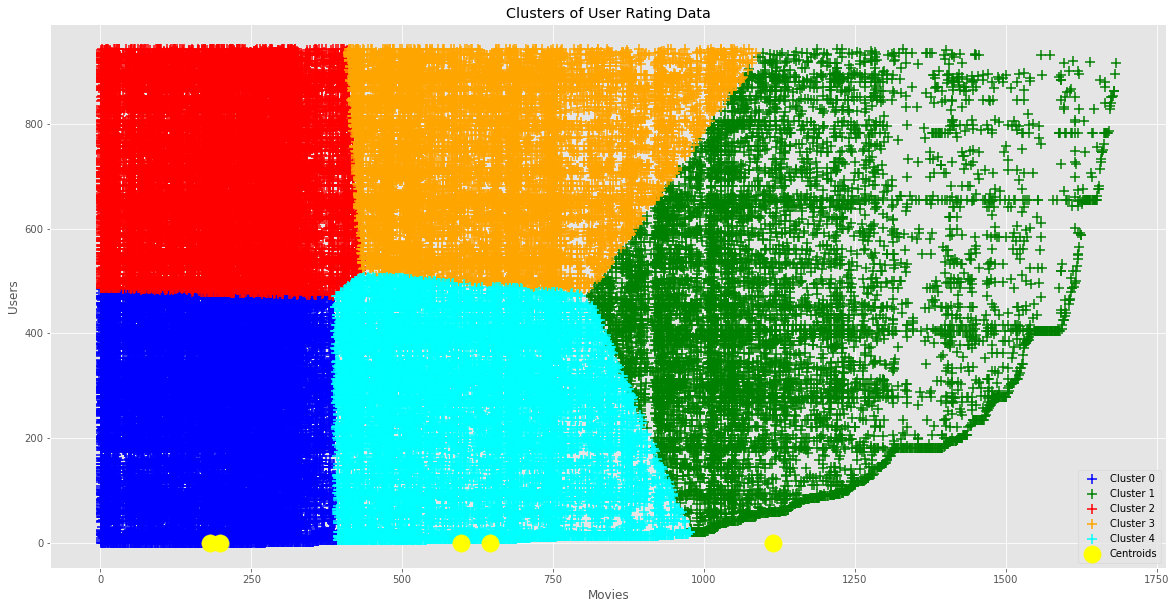

In [69]:
## Plot the clusters
X = np.array(data)

plt.figure(figsize=(20,10))
colour=['blue','green','red','orange','cyan','black','pink','magenta']
for i in range(n_clusters):
    plt.scatter(X[clusters == i, 0], X[clusters == i, 20], s = 100, color=colour[i], marker='+', label = 'Cluster '+str(i))
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 19], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of User Rating Data')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.legend()
plt.show()

In [70]:
## Predict clusters for the test Data
y_pred_test = kmeans.predict(test_data)
print("Cluster Prediction of the test data")
print_df_info(pd.DataFrame(y_pred_test))

Cluster Prediction of the test data
Shape  (20000, 1)



,0
0,3
1,0
2,4
3,2
4,0


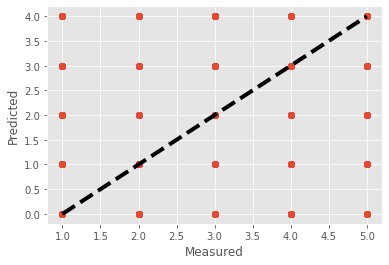

In [71]:
fig, ax = plt.subplots()
ax.scatter(vs_target_test, y_pred_test)
ax.plot([vs_target_test.min(), vs_target_test.max()], [y_pred_test.min(), y_pred_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


#### Evaluate Clusters using Silhouetes

In [72]:
%%time

silhouettes = silhouette_samples(data,clusters)

Wall time: 1min 26s


In [73]:
%%time

## silhouettes mean
sl_mean = silhouettes.mean()
print(" silhouettes.mean : ",sl_mean)

 silhouettes.mean :  0.3890200392446858
Wall time: 0 ns


In [74]:
%%time

## plot the silhouette


def plot_silhouettes(data, clusters, metric='euclidean'):
    
    
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data, clusters, metric='euclidean')
    c_ax_lower, c_ax_upper = 0, 0
    cticks = []
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[clusters == k]
        c_silhouette_vals.sort()
        c_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        pl.barh(range(c_ax_lower, c_ax_upper), c_silhouette_vals, height=1.0, 
                      edgecolor='none', color=color)

        cticks.append((c_ax_lower + c_ax_upper) / 2)
        c_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    pl.axvline(silhouette_avg, color="red", linestyle="--") 

    pl.yticks(cticks, cluster_labels)
    pl.ylabel('Cluster')
    pl.xlabel('Silhouette coefficient')

    pl.tight_layout()
    #pl.savefig('images/11_04.png', dpi=300)
    pl.show()
    
    return

Wall time: 0 ns


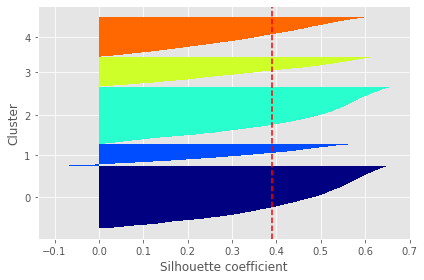

Wall time: 3min 29s


In [75]:
%%time
plot_silhouettes(data,clusters)

 #### Next, compare the clusters to the pre-assigned classes by computing the Completeness and Homogeneity values of the generated clusters

In [76]:
%%time
classes_arr = np.array(vs_target_train)

print(" classes_arr : ",classes_arr.max())
print(" clusters    : ",clusters)
print(" unique clusters - ",np.unique(clusters))
print(" unique ratings - ",np.unique(classes_arr))

print("completeness_score : ",completeness_score(classes_arr,kmeans.labels_))
print("homogeneity_score : ",homogeneity_score(classes_arr,kmeans.labels_))

 classes_arr :  5
 clusters    :  [4 4 0 ... 0 4 4]
 unique clusters -  [0 1 2 3 4]
 unique ratings -  [1 2 3 4 5]
completeness_score :  0.008591603795819101
homogeneity_score :  0.009007570588426168
Wall time: 38.1 ms


In [77]:

def calculateCosineSimilarityDistance(x,D):
    
    D_norm = np.linalg.norm(D) #np.array([np.linalg.norm(D[i]) for i in range(len(D))])
    x_norm = np.linalg.norm(x)
    #print("D_norm ",D_norm," x_norm ",x_norm)
    sims = np.dot(D,x)/(D_norm * x_norm)
    # The distance measure will be the inverse of Cosine similarity
    dist = 1 - sims
    
    return dist

In [78]:
centroids =  kmeans.cluster_centers_
print(" centroids ")
print_df_info(pd.DataFrame(centroids))
print("\n\n kmeans Score ",kmeans.score)

 centroids 
Shape  (5, 45)



,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,182.262909,2.960206e-04,0.306847,0.149237,0.029348,0.059923,0.296359,0.109612,0.005540,0.408212,...,0.022117,0.012095,0.092147,0.071468,0.018565,0.011714,0.018226,0.212670,0.039244,0.045333
1,1113.923659,1.219512e-04,0.115488,0.085732,0.033780,0.075732,0.351585,0.048537,0.024878,0.421341,...,0.013537,0.011951,0.095732,0.075000,0.017317,0.008780,0.013293,0.249268,0.028659,0.062073
2,198.168638,4.601298e-05,0.322689,0.166429,0.034280,0.067547,0.304146,0.106336,0.003313,0.390742,...,0.019095,0.004325,0.126214,0.089035,0.010031,0.006074,0.030138,0.233424,0.037132,0.061243
3,645.519770,1.639856e-18,0.201592,0.118001,0.041928,0.082441,0.267138,0.038832,0.007077,0.399204,...,0.014949,0.002477,0.127731,0.089518,0.006900,0.005130,0.023972,0.216718,0.033525,0.065281
4,597.569170,4.350361e-18,0.202051,0.116904,0.045848,0.086867,0.284883,0.046113,0.008138,0.383460,...,0.020377,0.013563,0.093219,0.065762,0.026067,0.010387,0.011181,0.201389,0.030963,0.052398




 kmeans Score  <bound method KMeans.score of KMeans(n_clusters=5, random_state=42)>


### check the clusters the test data set belongs to

In [79]:
%%time

results = []

#vs_test = np.array(test_data.values)
vs_test = np.array(test_data)
for doc in vs_test:
    dic = {}
    sim = []
    cluster = 0
    for centroid in centroids:
        #print("d ",doc)
        val = np.ravel(calculateCosineSimilarityDistance(doc,centroid))[0]
        #print("val ",val)
        centroid_doc_sim = 1 - val #Need to subtract from 1 as our function returns distance and not similarity
        #print("centroid_doc_sim ",centroid_doc_sim)
        sim.append(centroid_doc_sim) 
        dic['Cosine Similarity to Cluster '+str(cluster + 1)] = str(np.ravel(centroid_doc_sim)[0])
        cluster += 1
        
    dic['Predicted Cluster'] = sim.index(max(sim))  + 1
    
    results.append(dic)

test_cluster = pd.DataFrame(results)

pd.options.display.max_rows = 500
print("Categorized test data shape ",test_cluster.shape)

test_cluster

Categorized test data shape  (20000, 6)
Wall time: 2.45 s


,Cosine Similarity to Cluster 1,Cosine Similarity to Cluster 2,Cosine Similarity to Cluster 3,Cosine Similarity to Cluster 4,Cosine Similarity to Cluster 5,Predicted Cluster
0,0.9709749266443517,0.9473510181494612,0.8299225818298578,0.9896729616080785,0.9537395914754079,4
1,0.8287627687946635,0.9972674072387474,0.5774536899735953,0.8727616657970524,0.9975985345173263,5
2,0.9631981670086912,0.9570109471270457,0.8118454390094377,0.9846469159701056,0.9627569041946067,4
3,0.9677369003524031,0.6841075712075371,0.9898764136356895,0.9365877857616146,0.701599167989405,3
4,0.9998434525737628,0.8367300775224643,0.9403573865752738,0.9918586954347244,0.8494902896871143,1
...,...,...,...,...,...,...
19995,0.8927455622177909,0.5220317540137089,0.9946037868111293,0.8514114880218381,0.5398102571155515,3
19996,0.9834837647232165,0.7386233856152672,0.9833902101554627,0.9629858215473304,0.753502032007716,1
19997,0.9385422497945908,0.9764292097609147,0.7641543010748039,0.9682034029067396,0.9800200307978685,5
19998,0.8956224385679766,0.5276853719421488,0.9952665596829007,0.8548790736681521,0.5453644933567039,3


In [80]:
rms = sqrt(mean_squared_error(vs_target_test, y_pred_test))
rms

2.568287367098939

In [81]:
print(accuracy_score(vs_target_test, y_pred_test) * 100)

14.580000000000002


## Recommendation Implementation
#### 1. Popularity Based Recommendation
#### 2. User Based Recommendation
#### 3. Item based Recommendation (Truncated SVD)
#### 4. KNN Based recommendation
#### 5. Comparision of Item based recommendation and knn based recommendation

##### Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.

## 1. Popularity Based Recommendation

In [82]:
print("Unique movie counts ",len(np.unique(final_dataset['item_id'])))

Unique movie counts  1682


In [83]:
#Getting the new dataframe which contains users who has given more than the 5 ratings

new_df=final_dataset.groupby("item_id").filter(lambda x:x['rating'].count() >=5)
print(new_df.shape)
print("Unique movie counts ",len(np.unique(new_df['item_id'])))

(99287, 28)
Unique movie counts  1349


In [84]:
no_of_ratings_per_movie = new_df.groupby(by='item_id')['rating'].count().sort_values(ascending=False)
print(no_of_ratings_per_movie)

item_id
50      583
258     509
100     508
181     507
294     485
       ... 
1333      5
439       5
1324      5
1138      5
1397      5
Name: rating, Length: 1349, dtype: int64


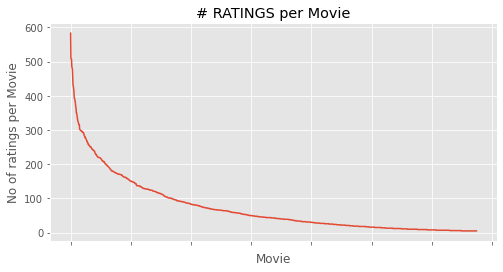

In [85]:
## plot number of ratings per movie
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of ratings per Movie')
ax.set_xticklabels([])

plt.show()

In [86]:
#Average rating of the movie (sorting in descending order)
new_df.groupby('item_id')['rating'].mean().sort_values(ascending=False).head()

item_id
1449    4.625000
408     4.491071
318     4.466443
169     4.466102
483     4.456790
Name: rating, dtype: float64

In [87]:
#Total no of ratings for movie  (sorting in descending order)
new_df.groupby('item_id')['rating'].count().sort_values(ascending=False).head()

item_id
50     583
258    509
100    508
181    507
294    485
Name: rating, dtype: int64

In [88]:
ratings_mean_count = pd.DataFrame(new_df.groupby('item_id')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('item_id')['rating'].count())
print_df_info(ratings_mean_count)

Shape  (1349, 2)



,rating,rating_counts
item_id,,
1,3.878319,452
2,3.206107,131
3,3.033333,90
4,3.550239,209
5,3.302326,86


In [89]:
print("Max # of ratings ",ratings_mean_count['rating_counts'].max())

Max # of ratings  583


Text(0.5, 1.0, 'Histogram for Rating mean count')

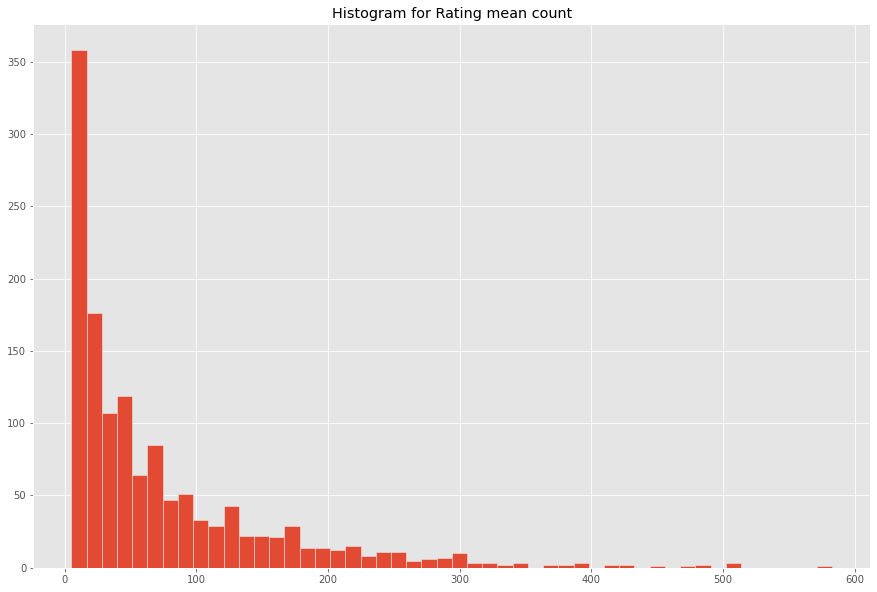

In [90]:
plt.figure(figsize=(15,10))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)
plt.title('Histogram for Rating mean count')

Text(0.5, 1.0, 'Histogram for Rating mean')

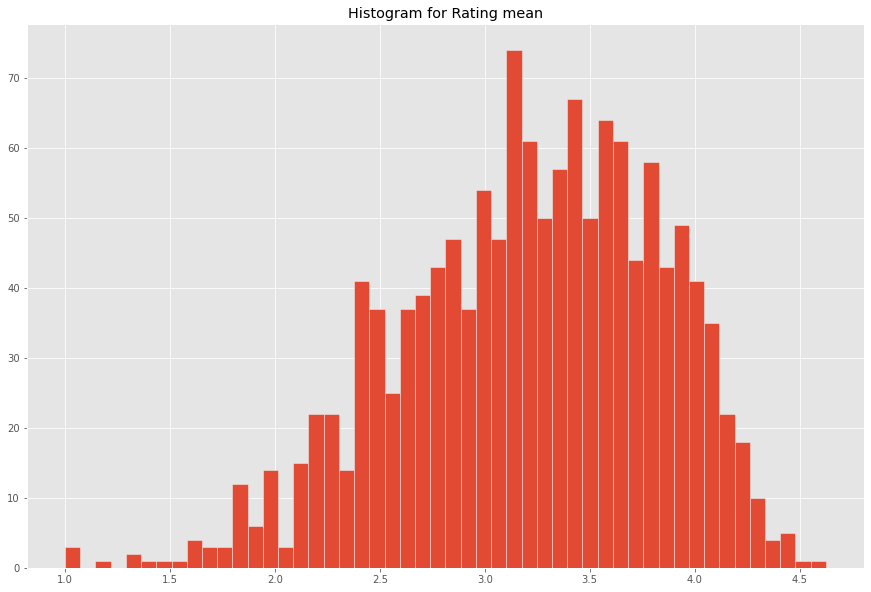

In [91]:
plt.figure(figsize=(15,10))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)
plt.title('Histogram for Rating mean')

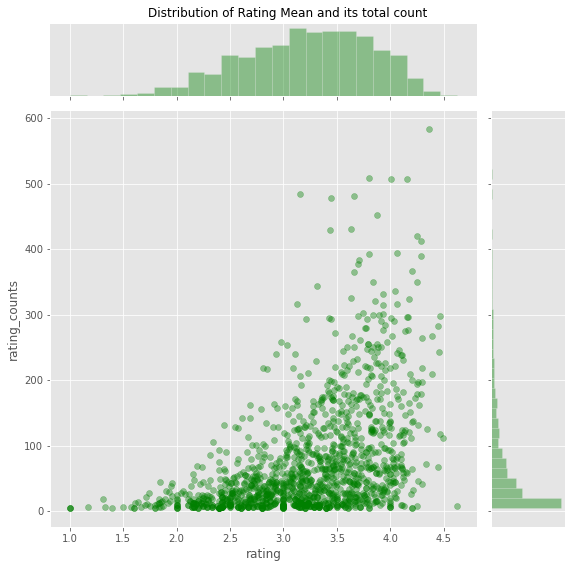

In [92]:
# #plt.figure(figsize=(30,20))
# plt.rcParams['patch.force_edgecolor'] = True
p = sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.39,height=8, color="green")
p.fig.suptitle("Distribution of Rating Mean and its total count")
p.fig.subplots_adjust(top=0.95)

### TOP 30 popular movies

top  30  popular movies are


,item_id,movie_name,No_of_ratings
0,50,Star Wars,583
1,258,Contact,509
2,100,Fargo,508
3,181,Return of the Jedi,507
4,294,Liar Liar,485
5,286,"English Patient, The",481
6,288,Scream,478
7,1,Toy Story,452
8,300,Air Force One,431
9,121,Independence Day (ID4),429


Wall time: 751 ms


<Figure size 1440x720 with 0 Axes>

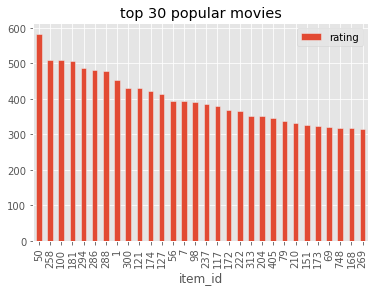

In [93]:
%%time
top_k = 30
movies = []


popular_movies = pd.DataFrame(new_df.groupby('item_id')['rating'].count())
most_popular = popular_movies.sort_values('rating', ascending=False)
most_popular.head


movie_id = most_popular.index
rating = np.array(pd.DataFrame(most_popular['rating']))
for i in range(len(movie_id)):
    #print(np.array(movie_data.loc[movie_data['movie_id']== movie_id[i]]['movie_title']))
    movies.append(np.array(movie_data.loc[movie_data['movie_id']== movie_id[i]]['movie_title'])[0])

top_popular_movies = pd.DataFrame(most_popular.index)
top_popular_movies['movie_name'] = movies
top_popular_movies['No_of_ratings'] = rating

plt.figure(figsize=(20,10))
most_popular.head(top_k).plot(kind = "bar",title="top "+str(top_k)+" popular movies")


print("top ",top_k," popular movies are")
display(top_popular_movies.head(top_k))


#### Popularity based recommendation system works with the trend. It basically uses the movies which are in trend right now. For example, if any movie which is usually watched by every new user then there are chances that it may suggest that movie to the test user.

#### The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend movies accordingly.

## Cluster Identification

### k means cluster on the data set and then predicting the cluster for a given data

In [94]:
## merged Data
print_df_info(final_data)

Shape  (100000, 46)



,item_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,4,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,5,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,8,0,0,0,0,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [95]:
%%time

wcss = []
k_range=8
for i in range(1, k_range):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(final_data)
    wcss.append(kmeans.inertia_)

Wall time: 19.3 s


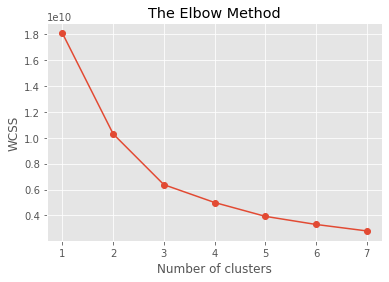

In [96]:
plt.plot(range(1, k_range,1), wcss,marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [97]:
#By Elbow meathods we found 3 clusters are optimal choice 
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(final_data)

KMeans(n_clusters=3)

In [98]:
new_data = final_data.copy()
# Creating an extra column in data for storing the cluster values
new_data['Cluster'] = kmeanModel.labels_
new_data['Cluster'].sample(n=10)

23731    0
68851    2
44025    2
15611    0
23179    0
64426    2
3055     1
89185    1
76403    2
22929    0
Name: Cluster, dtype: int32

In [99]:
new_data['Cluster'].value_counts()

0    40112
2    34537
1    25351
Name: Cluster, dtype: int64

In [100]:
# After merging the dataframe for a single movie multiple rows were created so a movie is allotted
# to many clusters. :et/s assign a single cluster to a movie 
# the Cluster which occurs maximum number of times is alloted to the movie  
e = []
def assignCluster(group):
    a = pd.DataFrame(group)
    b = pd.DataFrame(a['Cluster'].value_counts())
    d = a.index 
    c = [a['item_id'][d[0]],int(b.idxmax())]
    e.append(c)

In [101]:
new_data.groupby("item_id").apply(lambda x: assignCluster(x))
cluster_df =  pd.DataFrame(e)
print_df_info(cluster_df)

Shape  (1683, 2)



,0,1
0,1,0
1,1,0
2,2,0
3,3,0
4,4,0


In [102]:
cluster_df.rename(columns = {0:'item_id',1:'Cluster #'},inplace=True)
cluster_df.drop_duplicates(inplace=True)

In [103]:
cluster_df.head()

,item_id,Cluster #
0,1,0
2,2,0
3,3,0
4,4,0
5,5,0


## User Based CF

In [104]:
## Item Based Recommendation
movies = movie_data
movies.columns = ['item_id','movie_title']
display(movies.head())
display(item_data.head())

,item_id,movie_title
0,1,Toy Story
1,2,GoldenEye
2,3,Four Rooms
3,4,Get Shorty
4,5,Copycat


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [105]:
print("Movie Data")
print_df_info(item_data)

Movie Data
Shape  (1682, 24)



,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat,01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [106]:
print_df_info(movies)

Shape  (1682, 2)



,item_id,movie_title
0,1,Toy Story
1,2,GoldenEye
2,3,Four Rooms
3,4,Get Shorty
4,5,Copycat


In [107]:
#Function to get the rating given by a user to a movie.
def get_rating_(ratings,userid,movieid):
    return (ratings.loc[(ratings.user_id==userid) & (ratings.item_id == movieid),'rating'].iloc[0])

# Function to get the list of all movie ids the specified user has rated.
def get_movieids_(ratings,userid):
    return (ratings.loc[(ratings.user_id==userid),'item_id'].tolist())

# Function to get the movie titles against the movie id.
def get_movie_title_(movieid):
    return (movies.loc[(movies.item_id == movieid),'movie_title'].iloc[0])

# Function to get the movie titles against the movie id.
def get_movie_id_by_title(title):
    return (movies.loc[(movies.movie_title == title),'item_id'].iloc[0])

def get_movie_genre_(movie_id):
    g = np.array(genre_data['Genre'])
    data_g= item_data.loc[item_data.movie_id==movie_id]
    gen = "";
    for i in range(len(g)):
        if(data_g[g[i]].iloc[0] == 1):
            if(len(gen) == 0):
                gen =g[i]
            else:
                gen +=" | "+g[i] 
    return gen

def get_movie_genre_by_title(title):
    g = np.array(genre_data['Genre'])
    data_g= item_data.loc[item_data.movie_title==title]
    gen = "";
    for i in range(len(g)):
        if(data_g[g[i]].iloc[0] == 1):
            if(len(gen) == 0):
                gen =g[i]
            else:
                gen +=" | "+g[i] 
    return gen

In [108]:
def distance_similarity_score(ratings, user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    both_watch_count = 0
    for element in ratings.loc[ratings.user_id==user1,'item_id'].tolist():
        if element in ratings.loc[ratings.user_id==user2,'item_id'].tolist():
            both_watch_count += 1
            
    if both_watch_count == 0 :
        return 0
    distance = []
    for element in ratings.loc[ratings.user_id==user1,'item_id'].tolist():
        if element in ratings.loc[ratings.user_id==user2,'item_id'].tolist():
            rating1 = get_rating_(ratings,user1,element)
            #print(rating1)
            rating2 = get_rating_(ratings,user2,element)
            distance.append(pow(rating1 - rating2, 2))
    total_distance = sum(distance)
    return 1/(1+sqrt(total_distance))

In [109]:
distance_similarity_score(user_rating_data,1,250)

0.08179977728257459

### Calculating Similarity Scores based on the distances have an inherent problem. We do not have a threshold to decide how much more distance between two users is to be considered for calculating whether the users are close enough or far enough. On the other side, this problem is resolved by pearson correlation method as it always returns a value between -1 & 1 which clearly provides us with the boundaries for closeness as we prefer.

In [110]:
def pearson_correlation_score(ratings,user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    both_watch_count = []
    for element in ratings.loc[ratings.user_id==user1,'item_id'].tolist():
        if element in ratings.loc[ratings.user_id==user2,'item_id'].tolist():
            both_watch_count.append(element)
    if len(both_watch_count) == 0 :
        return 0
   
    rating_sum_1 = sum([get_rating_(ratings,user1,element) for element in both_watch_count])
    rating_sum_2 = sum([get_rating_(ratings,user2,element) for element in both_watch_count])
    
    rating_squared_sum_1 = sum([pow(get_rating_(ratings,user1,element),2) for element in both_watch_count])
    rating_squared_sum_2 = sum([pow(get_rating_(ratings,user2,element),2) for element in both_watch_count])
    
    product_sum_rating = sum([get_rating_(ratings,user1,element) * get_rating_(ratings,user2,element) for element in both_watch_count])
    
    numerator = product_sum_rating - ((rating_sum_1 * rating_sum_2) / len(both_watch_count))
    denominator = sqrt((rating_squared_sum_1 - pow(rating_sum_1,2) / len(both_watch_count)) * (rating_squared_sum_2 - pow(rating_sum_2,2) / len(both_watch_count)))
    if denominator == 0:
        return 0
    return numerator/denominator

In [111]:
print("Similarity between user 10 and 610")
pearson_correlation_score(user_rating_data, 10,610)

Similarity between user 10 and 610


0.43645948320032646

## Most Similar Users
#### The objective is to find out Most Similar Users to the targeted user. Here we have two metrics to find the score i.e. distance and correlation.

In [112]:

def most_similar_users_(ratings, user1,number_of_users,metric='pearson'):
    '''
    user1 : Targeted User
    number_of_users : number of most similar users you want to user1.
    metric : metric to be used to calculate inter-user similarity score. ('pearson' or else)
    '''
    # Getting distinct user ids.
    user_ids = ratings.user_id.unique().tolist()
    
    # Getting similarity score between targeted and every other user in the list.
    if(metric == 'pearson'):
        similarity_score = [(pearson_correlation_score(ratings,user1,nth_user),nth_user) for nth_user in user_ids if nth_user != user1]
    else:
        similarity_score = [(distance_similarity_score(ratings,user1,nth_user),nth_user) for nth_user in user_ids if nth_user != user1]
    
    # Sorting in descending order.
    similarity_score.sort()
    similarity_score.reverse()
    
    similar_users = pd.DataFrame(similarity_score,columns=['similarity_score','user_id'])
    
    # Returning the top most 'number_of_users' similar users. 
    return similar_users.iloc[:number_of_users]

## Getting Movie Recommendations for Targeted User
### The concept is very simple. First, we need to iterate over only those movies not watched(or rated) by the targeted user and the subsetting items based on the users highly correlated with targeted user. Here, we have used a weighted similarity approach where we have taken product of rating and score into account to make sure that the highly similar users affect the recommendations more than those less similar. Then, we have sorted the list on the basis of score along with movie ids and returned the movie titles against those movie ids.

In [113]:
def get_recommendation_(ratings, userid,top_k=10, top_N_similar_users=500):
    
    ## get the top_N similar users
    most_similar_user_df = most_similar_users_(ratings,test_user_id,top_N_similar_users)
    
    user_ids = most_similar_user_df.user_id.unique().tolist()
    total = {}
    similariy_sum = {}
    
    # Iterating over subset of user ids.
    for user in user_ids:
        
        # not comparing the user to itself (obviously!)
        if user == userid:
            continue
        
        # Getting similarity score between the users.
        score = pearson_correlation_score(ratings,userid,user)
        
        # not considering users having zero or less similarity score.
        if score <= 0:
            continue
        
        # Getting weighted similarity score and sum of similarities between both the users.
        for movieid in get_movieids_(ratings,user):
            # Only considering not watched/rated movies
            if movieid not in get_movieids_(ratings,userid) or get_rating_(ratings,userid,movieid) == 0:
                total[movieid] = 0
                total[movieid] += get_rating_(ratings,user,movieid) * score
                similariy_sum[movieid] = 0
                similariy_sum[movieid] += score
    
    #print(" total ",total)
    # Normalizing ratings
    ranking = [(tot/similariy_sum[movieid],movieid) for movieid,tot in total.items()]
    ranking.sort()
    ranking.reverse()
    
    # Getting movie titles against the movie ids.
    recommendations = pd.DataFrame(ranking,columns=['rating','movie_id'])
    recomm_movies = []
    mov_gen = []
    for score,movieid in ranking:
        recomm_movies.append(get_movie_title_(movieid))
        mov_gen.append(get_movie_genre_(movieid))
    
    recommendations['movie_name']=recomm_movies
    recommendations['genre']=mov_gen
    
    print("Input User Id ",userid)
    print("Top 10 similar users are...")
    display(most_similar_user_df.head(10))
    
    
    print("Using User based CF - Top 10 movie Recommendation for test user ",userid)
    print()
    print(recommendations.iloc[:top_k].to_markdown())

    return recommendations.iloc[:top_k]

In [ ]:
%%time
test_user_id = 320
recommended_data = get_recommendation_(user_rating_data,test_user_id)

## Item base CF

In [ ]:
movie_data.columns = ['item_id','movie_title']

In [ ]:
movies.columns = ['item_id','movie_title']
print_df_info(movies)

In [ ]:
print_df_info(user_rating_data)

In [ ]:
# pivot ratings into movie features
rating_crosstab = user_rating_data.pivot(
    index='user_id',
    columns='item_id',
    values='rating'
).fillna(0)

display(rating_crosstab)

In [ ]:
rating_crosstab.loc[1]

In [ ]:
## Since we want the item-based collaborative filtering we will transpose the rating_crosstab matrix.
X = rating_crosstab.T
print_df_info(X)

In [ ]:
%%time
movie_ids = rating_crosstab.columns
movie_titles = []
genre = []

## populate genre and movie titles
for id in movie_ids:
    genre.append(get_movie_genre_(id))
    movie_titles.append(movie_data.loc[movie_data['item_id'] == id]['movie_title'].iloc[0])
    

In [ ]:
SVD = TruncatedSVD(n_components=12, random_state=5)
resultant_matrix = SVD.fit_transform(X)

### correlation matrix
corr_mat = np.corrcoef(resultant_matrix)

print(" resultant_matrix.shape ",resultant_matrix.shape)

print(" corr_mat.shape ",corr_mat.shape)


In [ ]:
SVD.explained_variance_ratio_

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0, 12), SVD.explained_variance_ratio_  , marker='^')
plt.xlabel(' # of Component')
plt.ylabel('Percentage of Variance')
plt.show()

In [ ]:
transformed_data = pd.DataFrame(SVD.fit_transform(X))
transformed_data.head()

In [ ]:
n_clusters =5
kmeans = KMeans(n_clusters=n_clusters);
kmeans.fit(transformed_data)
clusters_reduced_dim = kmeans.predict(transformed_data)
centroids_reduced_dim = pd.DataFrame(kmeans.cluster_centers_)

print("clusters_reduced_dim ")
print_df_info(pd.DataFrame(clusters_reduced_dim))
print("\ncentroids_reduced_dim ")
print_df_info(pd.DataFrame(centroids_reduced_dim))

In [ ]:
%%time

silhouettes_reduced_dim = silhouette_samples(transformed_data,clusters_reduced_dim)
print(" silhouettes_reduced_dim ",silhouettes_reduced_dim[:5])

plot_silhouettes(transformed_data,clusters_reduced_dim)

In [ ]:
### correlation matrix - by movie id
def get_similar_movies(movie_id,top_k=10):
    col_idx = rating_crosstab.columns.get_loc(movie_id)
    corr_specific = corr_mat[col_idx]
    corr_df = pd.DataFrame({'corr_specific':corr_specific, 'movie_id': movie_ids})
    corr_df['movie_title']=movie_titles
    corr_df['genre'] = genre
    #corr_df.reindex(index=movie_ids)
    similar_movies = corr_df.sort_values('corr_specific', ascending=False).head(top_k)
    print("using item based CF the Top ",top_k,"movies similar to ",movie_data.loc[movie_data['item_id'] == movie_id]['movie_title'].iloc[0], "(Id = ",movie_id," - genre  ",get_movie_genre_(movie_id),")")
    display(similar_movies)
    return similar_movies

### correlation matrix - by movie name
def get_similar_movies_by_title(title,top_k=10):
    print("Input ")
    display(movie_data.loc[movie_data['movie_title'] == title])
    query_id = movie_data.loc[movie_data['movie_title'] == title]['item_id'].iloc[0]
    df = get_similar_movies(query_id,top_k)

## Similar Movies to Star Wars - Id=50

In [ ]:
movie_data.loc[movie_data['movie_title'] == "Star Wars"]

In [ ]:
df = get_similar_movies_by_title("Star Wars",15)

### Similar Movies to Gone with the Wind (1939)

In [ ]:
df = get_similar_movies_by_title('Gone with the Wind',15)

## Observation

### As we saw above that every movie has a ~100% Correlation Pearson with itself as expected. 

#### With the Item-Based collaborative filter we can recommend movies based on user preference. For example, if someone likes the “Gone with the Wind” we can recommend the user to watch the ”My Fair Lady“. 

#### It works also on the other way around. If someone does not like the ” Star Wars” we can suggest the user to avoid watching the “Return of the Jedi“

## Movie Recommendations using KNearestNeighbors 

In [ ]:
print_df_info(movies)

In [ ]:
print_df_info(user_rating_data)

In [ ]:
## add movie title to the data frame
ratings_df = pd.merge(user_rating_data,movies[['movie_title','item_id']],left_on='item_id',right_on='item_id')
print_df_info(ratings_df)

In [ ]:
## check for any missing values
ratings_df.isnull().sum()

In [ ]:
## number of ratings for each movie
ratings_count = ratings_df.groupby(by="movie_title")['rating'].count().reset_index().rename(columns={'rating':'totalRatings'})[['movie_title','totalRatings']]

In [ ]:
print("Ratings Data")
print_df_info(ratings_count)

In [ ]:
## # of unique movies
len(ratings_df['movie_title'].unique())

In [ ]:
## a dataframe with userid, movieid, title and rating
ratings_total = pd.merge(ratings_df,ratings_count,on='movie_title',how='left')
print("ratings_total")
print_df_info(ratings_total)

In [ ]:
## five point summary
ratings_count['totalRatings'].describe()

In [ ]:
## There is a huge difference between minimum number of ratings and maximum number of ratings.

In [ ]:
quantiles = ratings_count['totalRatings'].quantile(np.arange(0,1.01,0.01))
display(quantiles)

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('Total Rating')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
## ignore data where total ratings is <10
votes_count_threshold = 10

In [ ]:
ratings_top = ratings_total.query('totalRatings > @votes_count_threshold')
print_df_info(ratings_top)

In [ ]:
## remove duplicate entries for [title,userId] pairs
if not ratings_top[ratings_top.duplicated(['user_id','movie_title'])].empty:
    ratings_top = ratings_top.drop_duplicates(['user_id','movie_title'])

In [ ]:
ratings_top.shape


In [ ]:
## create pivot table for KNN
df_for_knn = ratings_top.pivot(index='movie_title',columns='user_id',values='rating').fillna(0)
print_df_info(df_for_knn)

In [ ]:
## using sparse matrix representation of this matrix
from scipy.sparse import csr_matrix
df_for_knn_sparse = csr_matrix(df_for_knn.values)

df_for_knn_sparse.shape

## Recommendations using KNearestNeighbors method

In [ ]:
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')

In [ ]:
model_knn.fit(df_for_knn_sparse)

In [ ]:
## print distance and movie indices for a test users
query_index = np.random.choice(df_for_knn.shape[0])
distances, indices = model_knn.kneighbors(df_for_knn.iloc[query_index,:].values.reshape(1,-1),n_neighbors=top_k)

print(" query_index ",query_index,"\n\n distances ",np.ravel(distances),"\n\n indices ",np.ravel(indices))

In [ ]:
df_for_knn.loc["12 Angry Men"]

In [ ]:
# def get_knn_recommendation_by_movie_id(query_movie_id,top_k=6):
    
    
    
def get_knn_recommendation(query_movie,top_k=6):
    
    distances, indices = model_knn.kneighbors(df_for_knn.loc[query_movie].values.reshape(1,-1),n_neighbors=top_k)

    print(" Input Movie = ",query_movie,"\n\n distance = ",np.ravel(distances),"\n Corresponding movies indices = ",indices)
    print()
    distance = []
    movie = []
    genre = []
    movieid = []
    for i in range(0,len(distances.flatten())):
        if i==0:
            print("Recommendations using knn for movie: {0} with genre as {1}\n".format(query_movie, get_movie_genre_by_title(query_movie)))
        else:
            print("{0}: {1}, with distance of {2}".format(i,df_for_knn.index[indices.flatten()[i]],distances.flatten()[i]))
            distance.append(distances.flatten()[i])
            movie.append(df_for_knn.index[indices.flatten()[i]])
            genre.append(get_movie_genre_by_title(df_for_knn.index[indices.flatten()[i]]))
            title = df_for_knn.index[indices.flatten()[i]]
            
            movieid.append(item_data.loc[item_data.movie_title==title]['movie_id'].iloc[0])
    
    df = pd.DataFrame({'distance':distance,'movie_id':movieid,'title':movie,'genre':genre})
    print("\n\nRecommended KNN DataFrame for ",query_movie," with genre as ",get_movie_genre_by_title(query_movie),"....")
    display(df)

In [ ]:
get_knn_recommendation("Kolya")

## Comparing KNN and item based CF recommendation 

In [ ]:
def compare_knn_itembased_recommen(query_movie,top_k=6):
    ## get knn recommendation
    print("============================== KNN ============================")
    get_knn_recommendation(query_movie,top_k)
    
    print()
    print("============================== item based CF ============================")
    ## get item based recommendation
    get_similar_movies_by_title(query_movie,top_k)


In [ ]:
%%time
compare_knn_itembased_recommen('Kolya',6)

# App Version - run it from main

In [ ]:
#This function select the cluster for a user according the the user choice
def validate_movie_title(val):
    return val in movie_data.movie_title

def validate_user_id(val):
    return val in user_data.user_id

def select_c():
    global l
    print('\n Enter 1 for User based CF\n Enter 2 for Item Based CF\n Enter 3 for knn \n Enter 4 for cluster check')
    l = int(input())
    if(l == 1):
        print('Enter user id')
        k = int(input())
        if(k>0 and validate_user_id(k)):
            print('please wait.. getting movies based on similar users...It might take 5-10 mins')
            get_recommendation_(user_rating_data,k)
        else:
            print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ",k," is an invalid input ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ")
    elif(l == 2):
        print("enter movie name e.g. Star wars")
        movie_name = input()
        if(len(movie_name)>0 and validate_movie_title(movie_name)):
            print('please wait.. getting similar movies')
            get_similar_movies_by_title(movie_name)
        else:
            print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ",movie_name," is an invalid input ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ")
    
    elif(l == 3):
        print("enter movie name e.g. Kolya")
        movie_name = str(input())
        if(len(movie_name) > 0 and validate_movie_title(movie_name)):
            print('please wait.. getting similar movies')
            get_knn_recommendation(movie_name)
        else:
            print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ",movie_name," is an invalid input ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ")
            
    else:
        print("enter movie name e.g. Kolya")
        movie_name = str(input())
        if(len(movie_name) > 0 and validate_movie_title(movie_name)):
            print('please wait.. getting cluster info')
            id = get_movie_id_by_title(movie_name)
            #print(id)
            if(id > 0):
                print(movie_name," (",get_movie_genre_(id),") belongs to Cluster #",cluster_df.loc[(cluster_df.item_id == id),'Cluster #'].iloc[0])
        else:
            print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ",movie_name," is an invalid input ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ")

In [ ]:

# This is the main function which recommend you movies
def main():
    ans = False
    while not ans:
        select_c()
        print('Do you like to try again (y/n)')
        abc = input() 
        if ((abc =='N') or (abc == 'n')):
            ans =True
        

In [ ]:
main()